In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# own utils # TODO resolve namespace pollution by restricitn g importis in init
from utils.configuration import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *
from scipy.special import logit

Train with GPU support.


# 1. Experiments and Paths

In [3]:
experiment_name = "tramdagpaper_exp6_1_linearDGP_ls"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Created new configuration file at /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls/configuration.json


# 2.  Data

- same experiment as in https://arxiv.org/pdf/2503.16206 6.1 Conitnous Case
- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

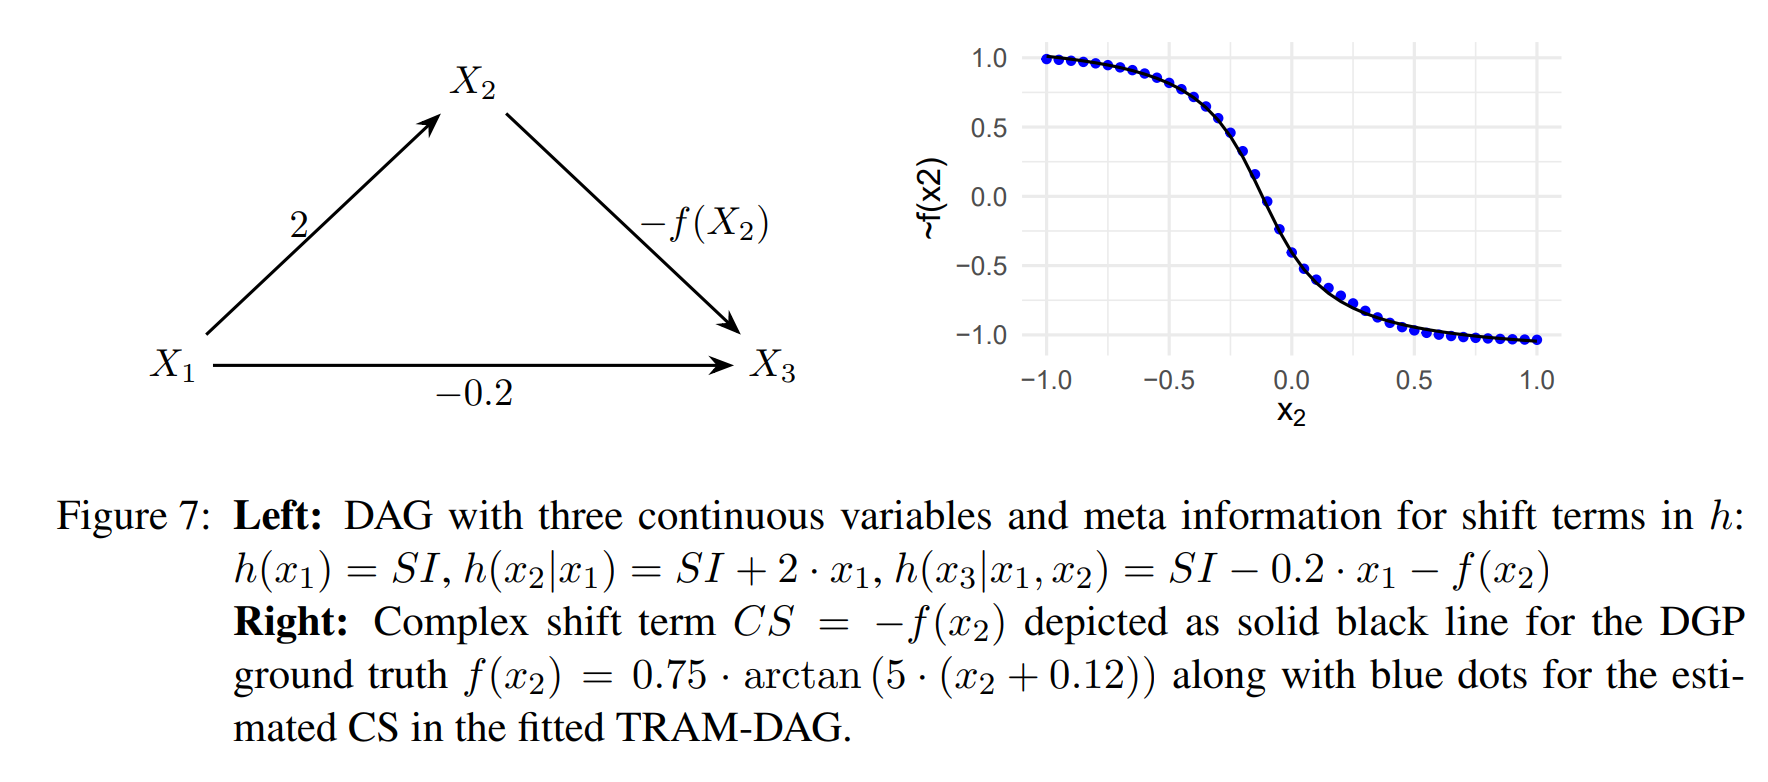

1. Linear-shift DGP and linear-shift model 

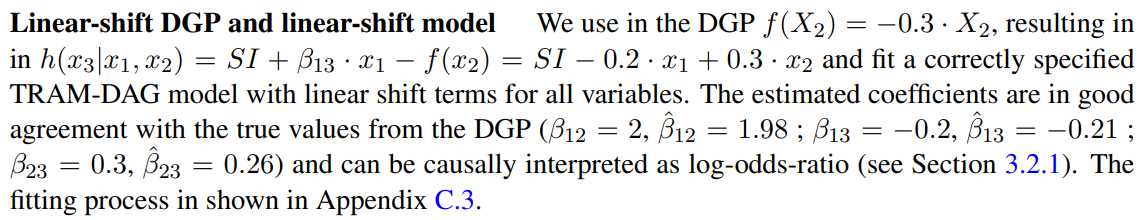

Setting Seed: 42
Loaded data from /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls/tramdagpaper_exp6_1_linearDGP_ls.csv
Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Variable 'x3' is modeled as a continuous variable. for target and predictor.
Configuration updated successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
dtypes: float64(3)
memory usage: 234.5 KB


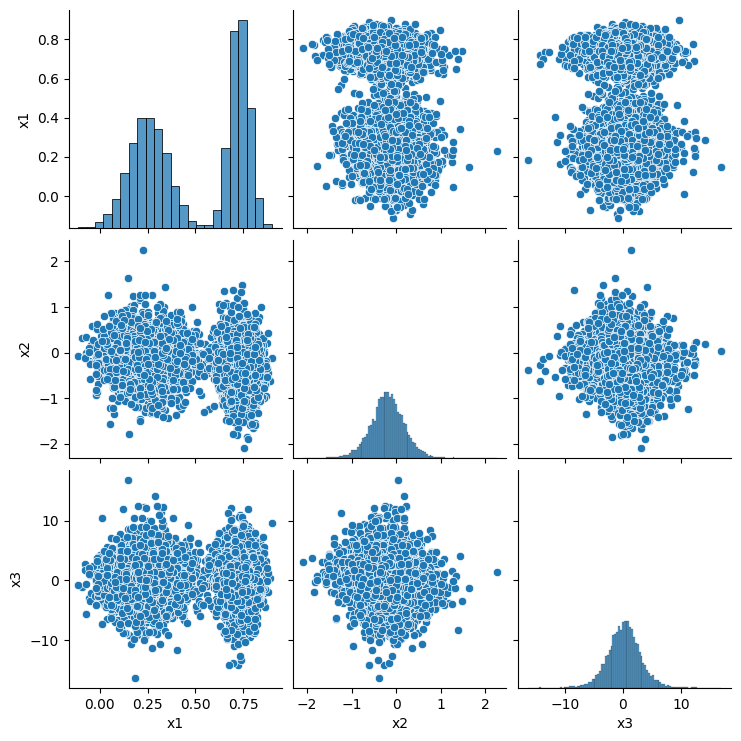

In [4]:
# 1. Linear-shift DGP and linear-shift model 
def f(x):
    return -0.3*x  

def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")
    
    # Generate x1 from a 2-component GMM
    
    # h(x1)= SI 
    
    
    if doX[0] is None:
        x1_A = np.random.normal(0.25, 0.1, n_obs)
        x1_B = np.random.normal(0.73, 0.05, n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, x1_A, x1_B)
    else:
        x1 = np.full(n_obs, doX[0])



    # Fz(z)=Fy(y)
    # Fz(h(y|x))=Fy(y)    | z= h(y|x)

    # Generate x2
    
    # h(x2|x1)= Bernsteinpol(x2) + beta2 * x1        | bernsteinpol is just linearized assumed with a constant factor say 0.42
    # h(x2|x1)= 0.42*x2 + beta2 * x1                 | replace h(x2|x1) with z
    # z       = 0.42*x2 + beta2 * x1                 | reformulate to x2
    # x2      = (z-beta2 * x1 )/0.42                 | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x2      = (z-beta2 * x1 )/0.42                 | set beta = 2 (on the edge of the graph)
    # x2      = (z-2 * x1 )/0.42                     |
    
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = logit(u2)
        x2 = (z2 - 2 * x1) / 5#5#   0.42  in the trainagle strucutred cont last line is 5 for SI
    else:
        x2 = np.full(n_obs, doX[1])

    # Generate x3
    
    # h(x3|x2,x1)= Bernsteinpol(x3) + beta3 * x1 -f(X2)        | bernsteinpol is just linearized assumed with a constant factor say 0.63
    # h(x3|x2,x1)= 0.63*x3 + beta3 * x1          - f(X2)        | replace h(x2|x1) with z
    # z3          = 0.63*x3 + beta3 * x1          - f(X2)        | reformulate to x2
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | set beta = -0.2 (on the edge of the graph)
    # x3         = (z3+0.2 * x1   +f(X2))/0.63                   | 

    
    if doX[2] is None:
        u3 = np.random.uniform(size=n_obs)
        z3 = logit(u3)
        x3 = (z3 + 0.2 * x1 + f(x2)) / 0.63
    else:
        x3 = np.full(n_obs, doX[2])
        
    #df = pd.DataFrame({'x1': x1, 'x2': x2})#, 'x3': x3})
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
    return df

n_obs=10_000

df = dgp(n_obs=n_obs, seed=42)

EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")

if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=100000, seed=42)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

sns.pairplot(df)

data_type= {'x1':'continous','x2':'continous','x3':'continous'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

df.info()

## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# # 3. Normalize all sets using training quantiles
# def normalize_with_quantiles(df, min_vals, max_vals):
#     return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


In [6]:

interactive_adj_matrix(CONF_DICT_PATH,seed=10)

No matrix found. Please fill out the DAG and click 'Generate'.


# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

In [7]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [8]:
levels_dict=create_levels_dict(df,data_type)

write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12053222464687426, 'max': 0.794692622870355, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.8142888901184293, 'max': 0.4238437120810543, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'continous', 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'continous', 'x2': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('ls')}, 'min': -4.421199142423371, 'max': 4.916709870336174,

In [ ]:
# hyperparams:
train_list=['x1','x2']#<-  set the nodes which have to be trained , useful if further training is required else lsit all vars
configuration_dict = load_configuration_dict(CONF_DICT_PATH)

# if you change the hyperparams -> write them to the config file!

In [ ]:
# For each NODE 
node_list = configuration_dict['nodes'] 

for node in node_list:
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    ########################## 0. Get hyperparameters ###############################
    batch_size, epochs, learning_rate, use_scheduler = get_hyperparameters_for_node(node,node_list)
    
    # ############ Edited hyperparameters ##########
    # batch_size = 512
    # epochs = 150
    # learning_rate = 0.01
    # use_scheduler = True
    # ###########################################
    

    print(f"Using hyperparameters: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, use_scheduler={use_scheduler}\n")

    
    ########################## 1. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (node_list[node]['node_type'] == 'source') and (node_list[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 2. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    

    ########################## 3. Check if training is complete ###############################
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    ########################## 4. Create Model ##############################
    tram_model= get_fully_specified_tram_model(node, node_list, verbose=True, set_initial_weights=False)
    
    
    
        # access the last linear layer in nn_int
    last_linear = tram_model.nn_int.fc  

    # get the weights
    weights = last_linear.weight.data  # tensor
    weights_numpy = last_linear.weight.detach().cpu().numpy()  # numpy array if you prefer

    print("Weights tensor:\n", weights)
    print("Weights shape:", weights.shape)
    
    

    ########################## 5. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, node_list, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, verbose=False)

    ########################## 6. Optimizer & Scheduler ######################.
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop(
                node,
                node_list,
                NODE_DIR,
                tram_model,
                train_loader,
                val_loader,
                epochs,
                optimizer,
                use_scheduler,
                scheduler,
                save_linear_shifts=False,
                verbose=1,
                device=device,
                debug=False) # TODO startvalues for bernsteinpols




----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 1000...
Epoch 1001/1500 | Train Loss: -0.5748 | Val Loss: -0.5583
  [Train: 1.90s | Val: 0.51s | Save: 0.01s | Total: 2.42s]
Epoch 1002/1500 | Train Loss: -0.5734 | Val Loss: -0.5583
  [Train: 0.87s | Val: 0.39s | Save: 0.01s | Total: 1.28s]
Epoch 1003/1500 | Train Loss: -0.5736 | Val Loss: -0.5582
  [Train: 0.96s | Val: 0.63s | Save: 0.02s | Total: 1.60s]
Epoch 1004/1500 | Train Loss: -0.5744 | Val Loss: -0.5584
  [Train: 1.16s | Val: 0.53s | Save: 0.01s | Total: 1.70s]
Epoch 1005/1500 | Train Loss: -0.5749 | Val Loss: -0.5584
  [Train: 1.14s | Val: 0.67s | Save: 0.02s |

In [ ]:
import subprocess
import tempfile
import textwrap

def fit_r_model_subprocess(target, dtype, data_path, verbose=False):
    
    # make sure that a valid R version is installed and Rscript is in PATH
    # make sure that the R packages MASS, tram, readr are installed
    # You can install them in R with:
    # install.packages(c("MASS", "tram", "readr"))
    
    # normalize dtype spelling
    dtype = dtype.lower().strip()
    if dtype in ["continous", "continuous"]:  # handle both spellings
        dtype = "continuous"
    elif dtype != "ordinal":
        raise ValueError(f"Unknown dtype: {dtype}")

    if dtype == "ordinal":
        r_code = textwrap.dedent(f"""
        library(MASS)
        library(tram)
        library(readr)

        data <- read_csv("{data_path}")
        data${target} <- factor(data${target}, ordered=TRUE)
        model <- polr({target} ~ 1, data=data, method="logistic")
        cat(model$zeta, sep="\\n")
        """)
    else:  # continuous
        r_code = textwrap.dedent(f"""
        library(MASS)
        library(tram)
        library(readr)

        data <- read_csv("{data_path}")
        model <- Colr({target} ~ 1, data=data, order=19)
        cat(model$theta, sep="\\n")
        """)

    # Write temporary R script
    with tempfile.NamedTemporaryFile(mode="w", suffix=".R", delete=False) as f:
        f.write(r_code)
        script_path = f.name

    if verbose:
        print("[DEBUG] R script written to:", script_path)
        print("[DEBUG] R code:\n", r_code)

    # Run Rscript
    result = subprocess.run(
        ["Rscript", script_path],
        capture_output=True,
        text=True
    )

    if result.returncode != 0:
        print("[DEBUG] Rscript failed")
        print("[DEBUG] STDOUT:\n", result.stdout)
        print("[DEBUG] STDERR:\n", result.stderr)
        raise RuntimeError("Rscript execution failed, see STDERR above")

    if verbose:
        print("[DEBUG] Rscript succeeded")
        print("[DEBUG] STDOUT:\n", result.stdout)

    # Parse numeric output
    try:
        values = [float(x) for x in result.stdout.strip().split("\n") if x]
    except ValueError:
        print("[DEBUG] Could not parse R output as floats")
        print("[DEBUG] Raw output:", result.stdout)
        raise

    return values


In [26]:
dtype='continous'
data_path=EXP_DATA_PATH
target="x1"

thetas=fit_r_model_subprocess(target, dtype, data_path,verbose=False)
thetas

[-2.254965,
 -1.762615,
 -1.003659,
 -1.003659,
 -0.9624353,
 -0.05844283,
 -0.05844282,
 -0.0584428,
 -0.05844279,
 -0.05844277,
 -0.05844276,
 -0.05844274,
 -0.05844273,
 -0.05844271,
 -0.0584427,
 -0.05844268,
 -0.05844267,
 0.4811235,
 1.182732,
 2.244193]

# 6 Inspect Training

## 6.1 Loss vs epochs

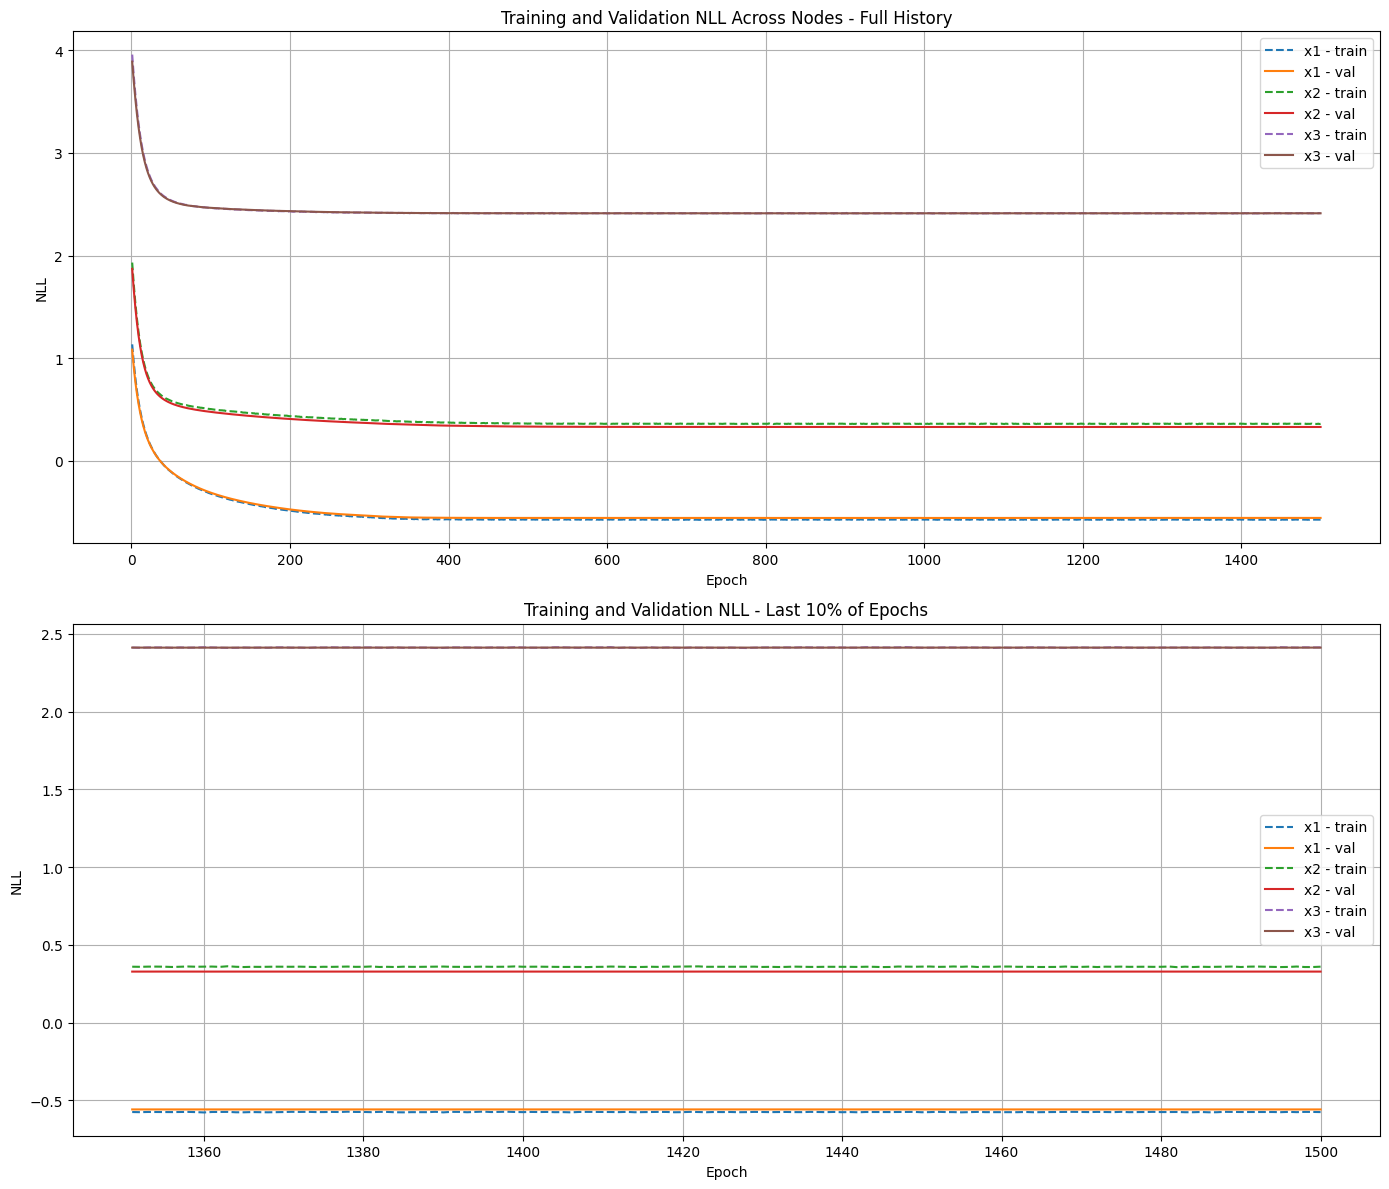

In [17]:
show_training_history(conf_dict,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


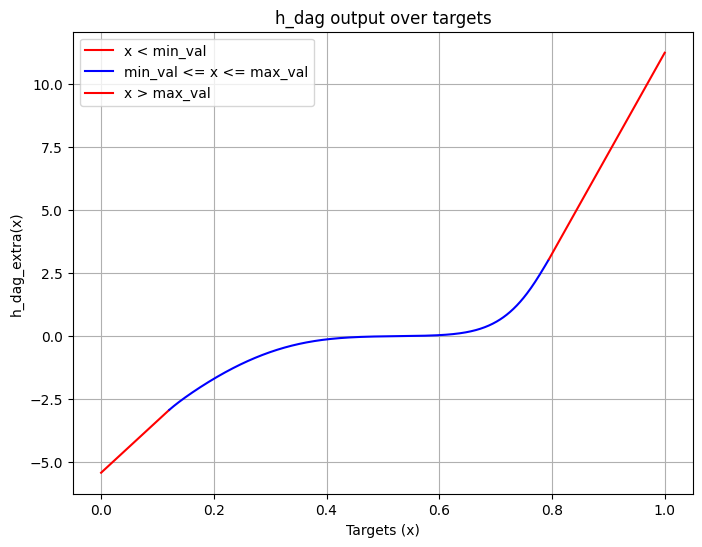


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [18]:
show_hdag_for_source_nodes(conf_dict,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=1) # TODO for other nodes funciton


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


Val loader (x1): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


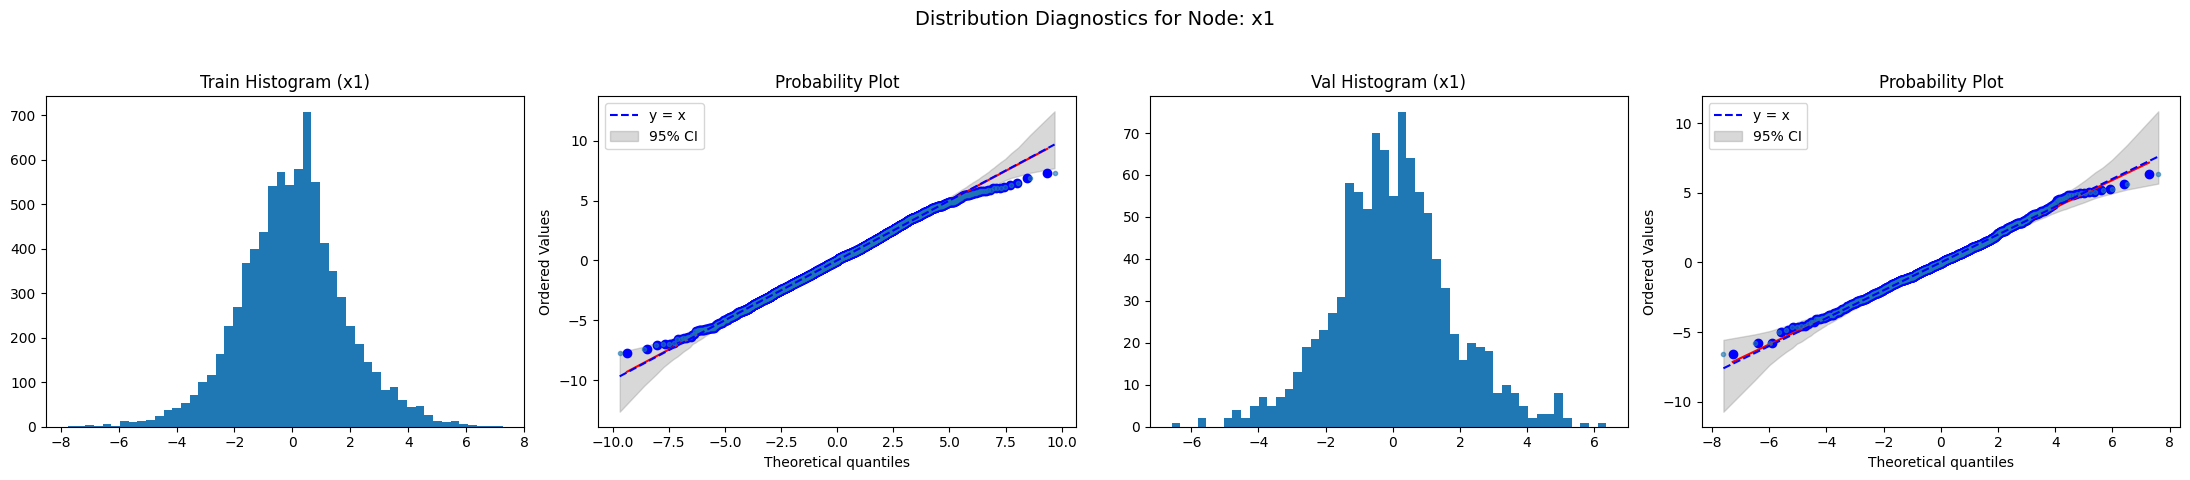


----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


Val loader (x2): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


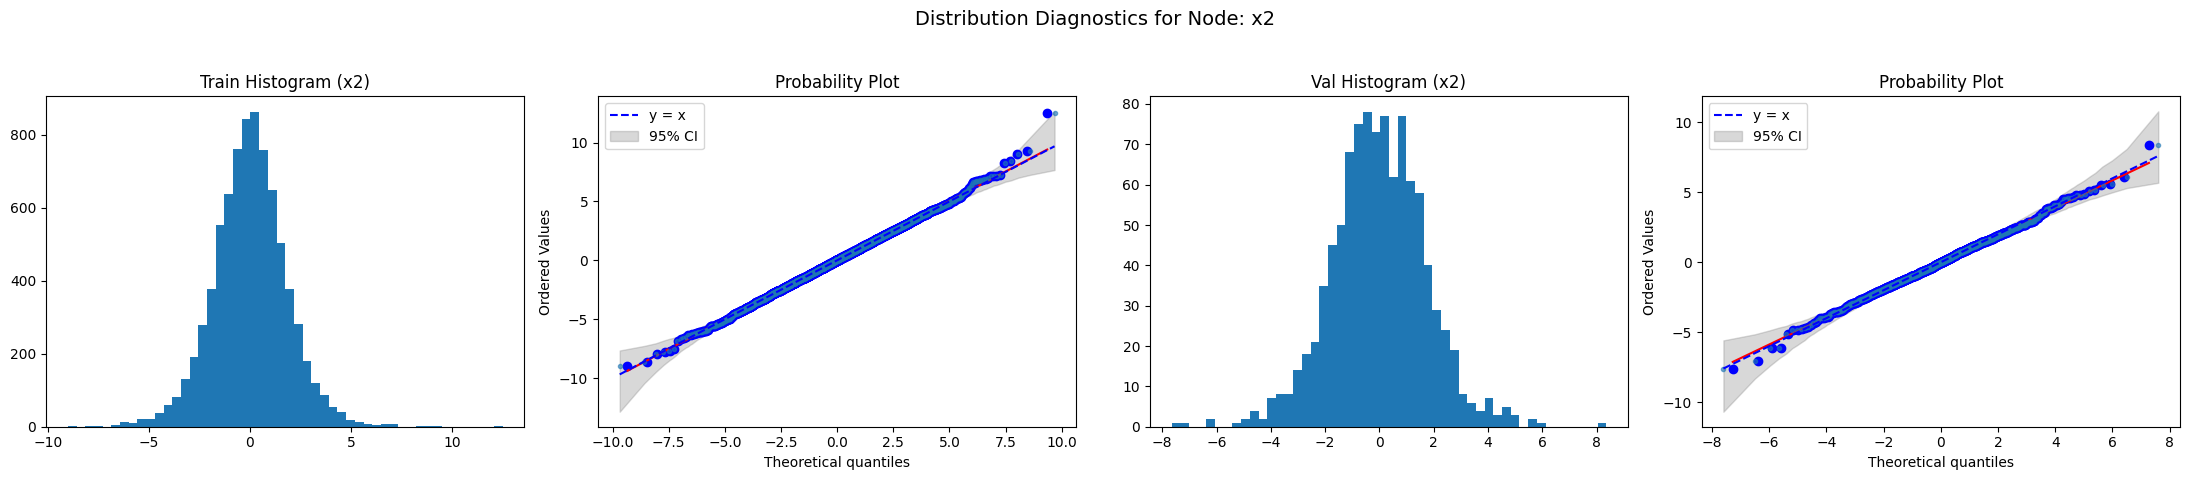


----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


Val loader (x3): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


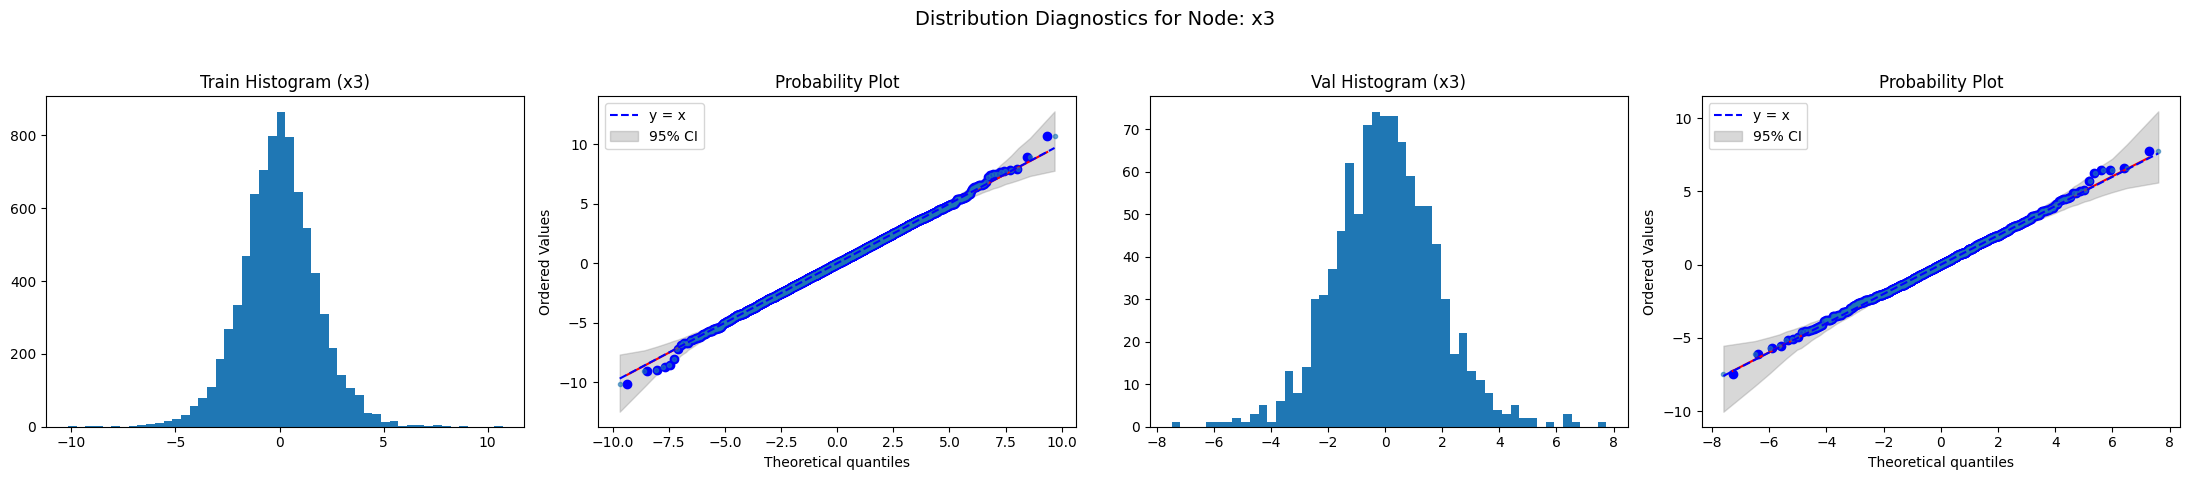

In [19]:
inspect_trafo_standart_logistic(conf_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficient estimates


----*----------*-------------*--------check LS of x1 ------------*-----------------*-------------------*--
Node type :source

----*----------*-------------*--------check LS of x2 ------------*-----------------*-------------------*--


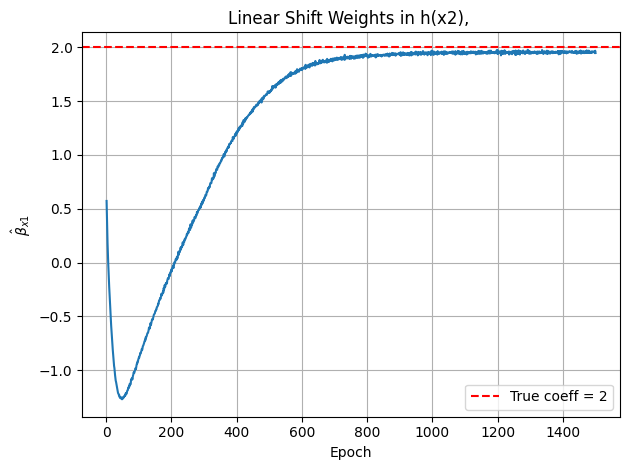


----*----------*-------------*--------check LS of x3 ------------*-----------------*-------------------*--


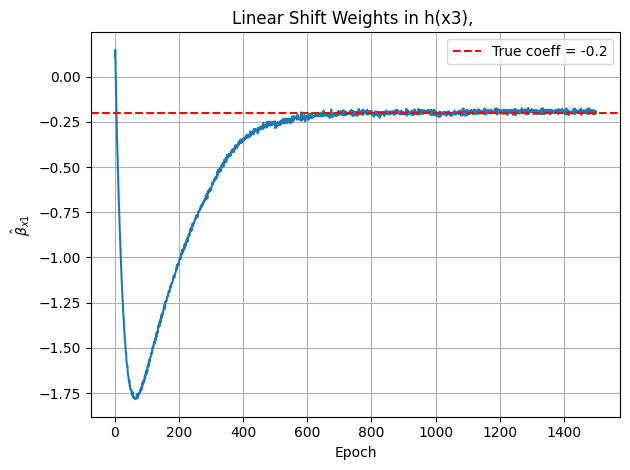

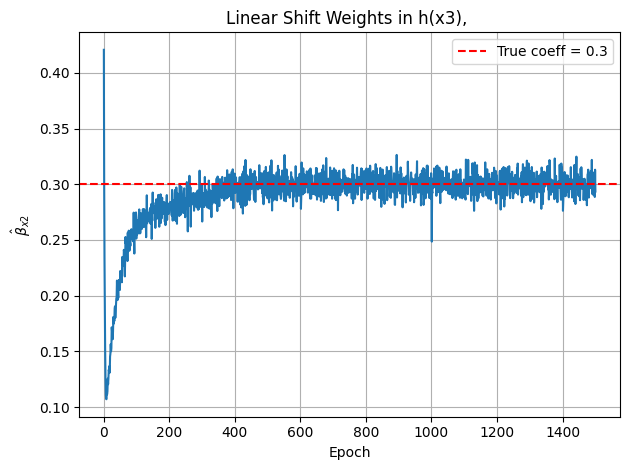

In [20]:
# x1-> x2, x1-> x3, x2-> x3
true_coeffs = {'x2': [2],'x3': [-0.2, 0.3]}

for node in conf_dict:
    print(f'\n----*----------*-------------*--------check LS of {node} ------------*-----------------*-------------------*--')
    
    if conf_dict[node]['node_type'] == 'source':
        print(f"Node type :source")
        continue
    
    # Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    # Load saved shifts
    shift_path = os.path.join(NODE_DIR, "linear_shifts_all_epochs.json")
    with open(shift_path, 'r') as f:
        all_shift_weights = json.load(f)

    # Sort epochs numerically
    epochs = sorted(all_shift_weights.keys(), key=lambda x: int(x.split('_')[1]))

    # Number of shifts (incoming edges) for this node
    example_epoch = all_shift_weights[epochs[0]]
    num_shifts = len(example_epoch)

    # Plot per shift (incoming edge)
    for shifts_idx in range(num_shifts):
        shift_name = f"shift_{shifts_idx}"
        weights_over_time = []

        for epoch in epochs:
            weight_matrix = np.array(all_shift_weights[epoch][shift_name])  # shape: [out_features, in_features]
            avg_weight = weight_matrix.mean()
            weights_over_time.append(avg_weight)

        plt.figure()
        plt.plot(range(1, len(epochs) + 1), weights_over_time)

        # If this node has a true coefficient for this shift, draw a horizontal red line
        if node in true_coeffs:
            true_val = true_coeffs[node][shifts_idx]
            plt.axhline(y=true_val, color='r', linestyle='--', label=f"True coeff = {true_val}")
            plt.legend()

        plt.title(f"Linear Shift Weights in h({node}), ")
        plt.xlabel("Epoch")
        plt.ylabel(fr'$\hat{{\beta}}_{{{conf_dict[node]["parents"][shifts_idx]}}}$')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

- best model , parameters

In [14]:
verbose=False
batch_size = 4112
for node in conf_dict:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    
    if (conf_dict[node]['node_type'] == 'source'):
        print(f"Node type : other , is not supported yet")
        continue
    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    
    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()
    
        
    for i in range(len(tram_model.nn_shift)):
        print(tram_model.nn_shift[i].fc.weight.data)
    


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
Node type : other , is not supported yet

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--
tensor([[1.9519]], device='cuda:0')

----*----------*-------------*--------check CS of x3 ------------*-----------------*-------------------*--
tensor([[-0.2296]], device='cuda:0')
tensor([[0.3170]], device='cuda:0')


# 7. Sample from Graph

In [21]:
sample_full_dag_chandru(conf_dict,
                            EXPERIMENT_DIR,
                            device,
                            n= 10_000,
                            batch_size = 1,
                            delete_all_previously_sampled=True,
                            verbose=True)     

Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls/x1/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x1: 100%|██████████| 10000/10000 [00:03<00:00, 2800.42it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:57<00:00, 174.74it/s]



----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls/x2/sampling
-- sampled latents
>>>>>>>>>>>> No ci detected --> intercept defaults to si
>>> TRAM MODEL:
 TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
-- loaded modelweights


h() for samples in  x2: 100%|██████████| 10000/10000 [00:05<00:00, 1788.67it/s]


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:57<00:00, 172.67it/s]



----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls/x3/sampling
-- sampled latents
>>>>>>>>>>>> No ci detected --> intercept defaults to si
>>> TRAM MODEL:
 TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0-1): 2 x LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
-- loaded modelweights


h() for samples in  x3: 100%|██████████| 10000/10000 [00:07<00:00, 1347.77it/s]


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:58<00:00, 172.02it/s]


## 7.3 Inspect Sampling

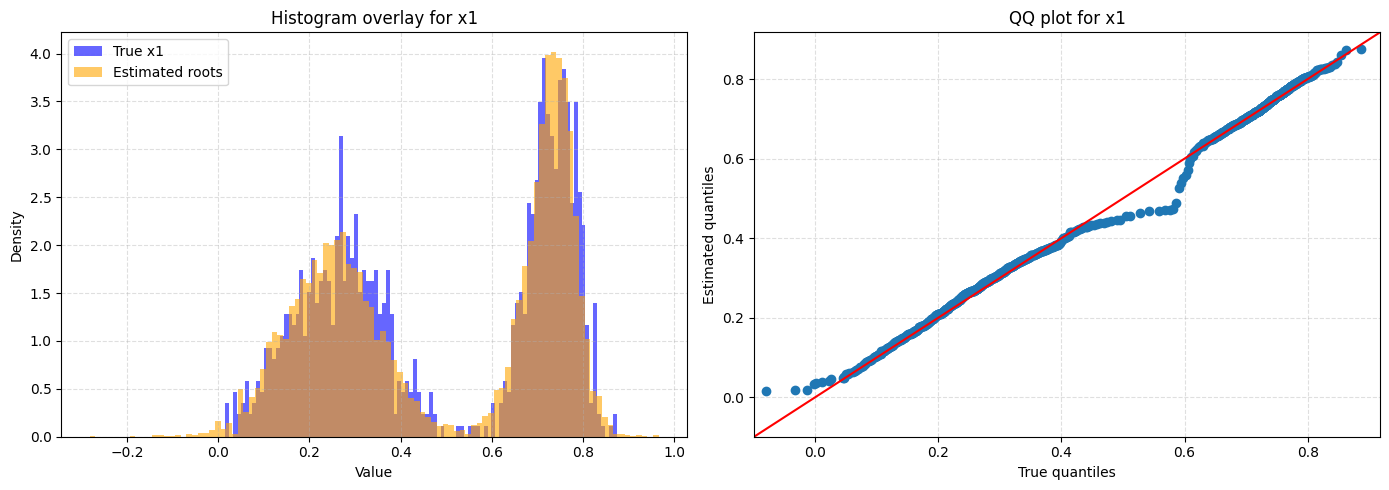

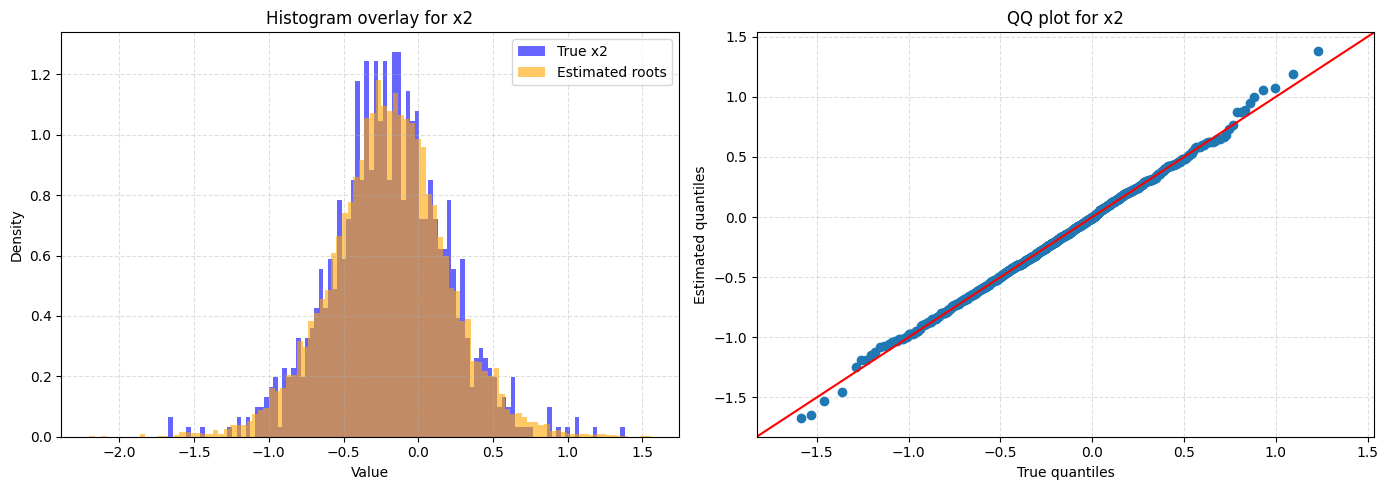

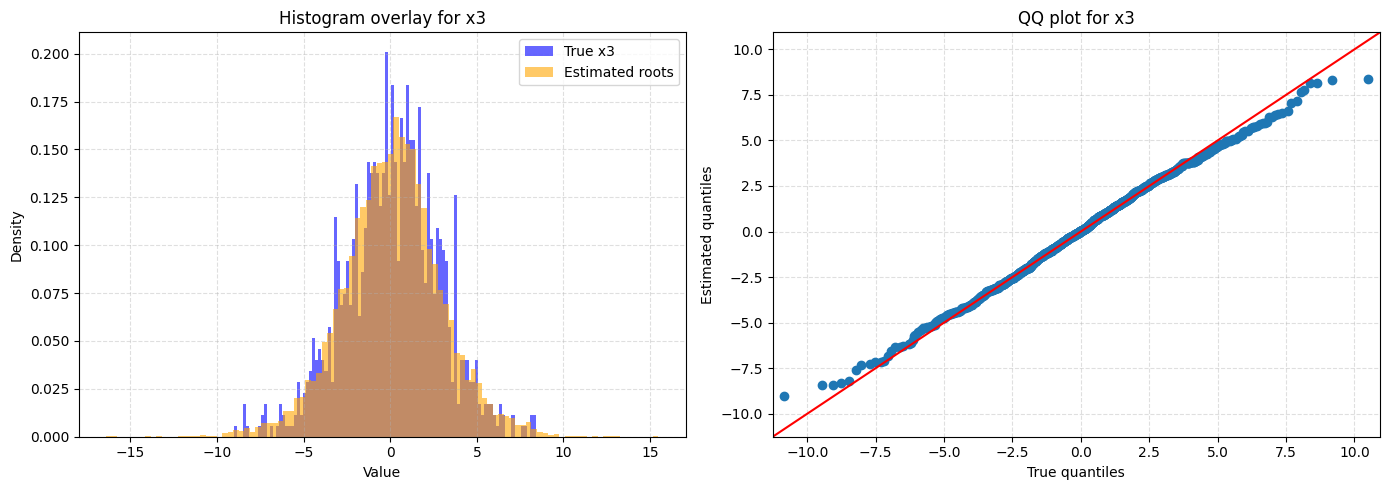

In [16]:
show_samples_vs_true(test_df,conf_dict,EXPERIMENT_DIR,rootfinder='chandrupatla')